In [10]:
# ============================================================================
# NOTEBOOK 3: Clustering Analysis
# File: 3_clustering_analysis.ipynb
# ============================================================================

# ============================================================================
# STEP 1: Import Libraries
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
from scipy.sparse import load_npz
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import TruncatedSVD
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

print("=" * 80)
print("Unsupervised Document Clustering Analysis")
print("=" * 80)


Unsupervised Document Clustering Analysis


In [11]:

# ============================================================================
# STEP 2: Load Preprocessed Data
# ============================================================================

print("\n" + "=" * 80)
print("Loading Preprocessed Data")
print("=" * 80)

# Load vectorizer
vectorizer = joblib.load('../artifacts/tfidf_vectorizer.joblib')
print("✓ Loaded: tfidf_vectorizer.joblib")

# # Load transformed feature matrices
# X_train = load_npz('X_train.npz')
# X_val = load_npz('X_val.npz')
# X_test = load_npz('X_test.npz')
# print("✓ Loaded: X_train.npz, X_val.npz, X_test.npz")
#
# # Load labels (for comparison purposes only, not used in clustering)
# y_train = np.load('y_train.npy', allow_pickle=True)
# y_val = np.load('y_val.npy', allow_pickle=True)
# y_test = np.load('y_test.npy', allow_pickle=True)
# print("✓ Loaded: y_train.npy, y_val.npy, y_test.npy")
artifacts_dir = '../artifacts'

data = joblib.load(os.path.join(artifacts_dir, 'preprocessed_data.joblib'))
vectorizer = joblib.load(os.path.join(artifacts_dir, 'tfidf_vectorizer.joblib'))

X_train = data['X_train']
X_val = data['X_val']
X_test = data['X_test']
y_train = data['y_train']
y_val = data['y_val']
y_test = data['y_test']
feature_names = data['feature_names']
class_names = data['class_names']
# Combine all data for clustering
X_all = np.vstack([X_train.toarray(), X_val.toarray(), X_test.toarray()])
y_all = np.concatenate([y_train, y_val, y_test])

print(f"\nCombined data shape: {X_all.shape}")
print(f"Total documents: {len(X_all)}")
print(f"Feature dimensions: {X_all.shape[1]}")

# Get feature names
feature_names = vectorizer.get_feature_names_out()
print(f"Number of features: {len(feature_names)}")



Loading Preprocessed Data
✓ Loaded: tfidf_vectorizer.joblib

Combined data shape: (2464, 5000)
Total documents: 2464
Feature dimensions: 5000
Number of features: 5000



Determining Optimal Number of Clusters

Using the Elbow Method to find optimal k:
- Test k values from 2 to 20
- Calculate inertia (within-cluster sum of squares)
- Look for the "elbow" point where adding more clusters doesn't
  significantly reduce inertia


Testing different values of k...
  k |      Inertia |   Silhouette | Time
--------------------------------------------------
  2 |      2280.68 |       0.0228 | 8.00s
  3 |      2248.06 |       0.0250 | 3.62s
  4 |      2224.60 |       0.0274 | 3.56s
  5 |      2201.44 |       0.0268 | 3.90s
  6 |      2176.87 |       0.0286 | 4.96s
  7 |      2162.16 |       0.0341 | 4.90s
  8 |      2152.51 |       0.0250 | 3.80s
  9 |      2138.95 |       0.0336 | 4.32s
 10 |      2128.61 |       0.0343 | 4.40s
 11 |      2113.38 |       0.0351 | 4.87s
 12 |      2108.82 |       0.0353 | 5.04s
 13 |      2092.07 |       0.0362 | 5.48s
 14 |      2083.99 |       0.0388 | 5.00s
 15 |      2069.75 |       0.0396 | 5.76s
 16 |      2063.03 |      

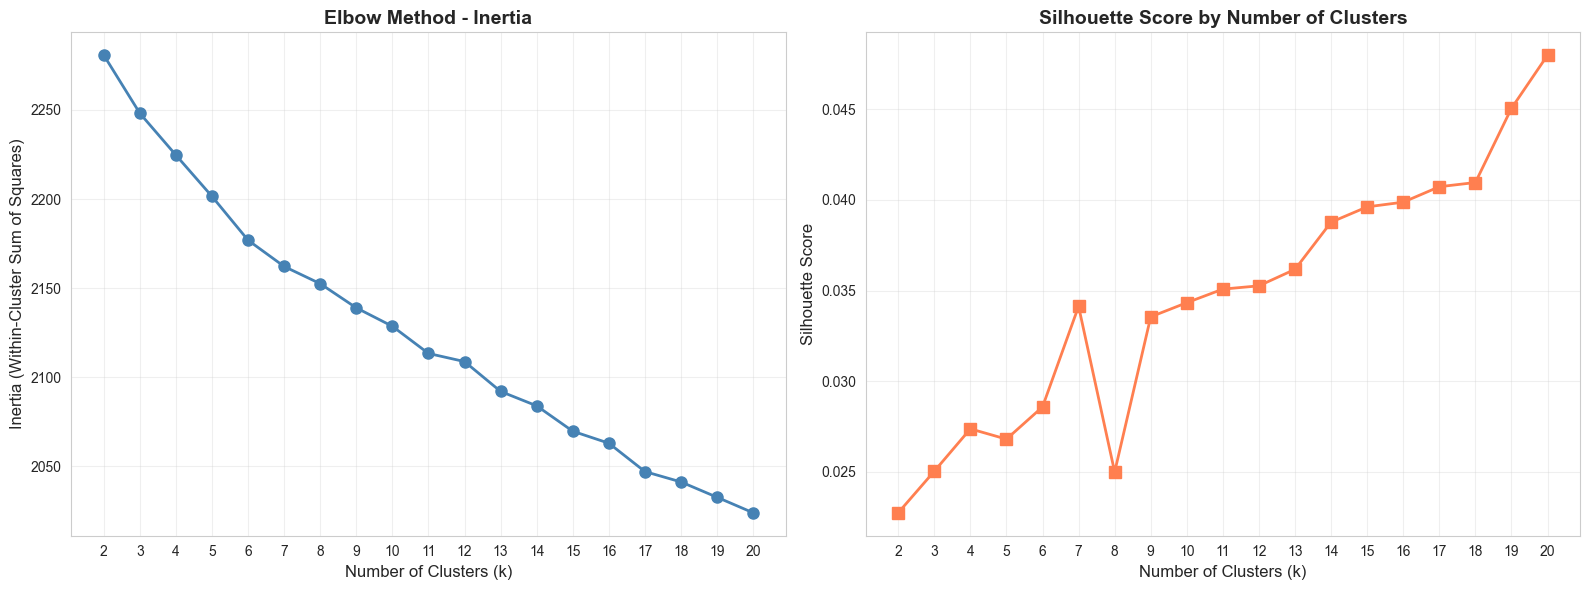


✓ Optimal k based on Silhouette Score: 20
  Maximum Silhouette Score: 0.0480

✓ Domain-based k (number of specialties): 13


In [12]:
# ============================================================================
# STEP 3: Determine Optimal Number of Clusters (Elbow Method)
# ============================================================================

print("\n" + "=" * 80)
print("Determining Optimal Number of Clusters")
print("=" * 80)

print("""
Using the Elbow Method to find optimal k:
- Test k values from 2 to 20
- Calculate inertia (within-cluster sum of squares)
- Look for the "elbow" point where adding more clusters doesn't
  significantly reduce inertia
""")

# Test different values of k
k_range = range(2, 21)
inertias = []
silhouette_scores = []

print("\nTesting different values of k...")
print(f"{'k':>3} | {'Inertia':>12} | {'Silhouette':>12} | Time")
print("-" * 50)

import time

for k in k_range:
    start_time = time.time()

    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300)
    cluster_labels = kmeans.fit_predict(X_all)

    inertia = kmeans.inertia_
    silhouette = silhouette_score(X_all, cluster_labels, sample_size=1000)

    inertias.append(inertia)
    silhouette_scores.append(silhouette)

    elapsed = time.time() - start_time
    print(f"{k:3d} | {inertia:12.2f} | {silhouette:12.4f} | {elapsed:.2f}s")

# Visualize elbow curve
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Elbow curve (Inertia)
axes[0].plot(k_range, inertias, marker='o', linewidth=2, markersize=8, color='steelblue')
axes[0].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[0].set_ylabel('Inertia (Within-Cluster Sum of Squares)', fontsize=12)
axes[0].set_title('Elbow Method - Inertia', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3)
axes[0].set_xticks(k_range)

# Silhouette score
axes[1].plot(k_range, silhouette_scores, marker='s', linewidth=2, markersize=8, color='coral')
axes[1].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[1].set_ylabel('Silhouette Score', fontsize=12)
axes[1].set_title('Silhouette Score by Number of Clusters', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)
axes[1].set_xticks(k_range)

plt.tight_layout()
plt.savefig('elbow_curve.png', dpi=300, bbox_inches='tight')
plt.show()

# Find optimal k (where silhouette score is highest)
optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"\n✓ Optimal k based on Silhouette Score: {optimal_k}")
print(f"  Maximum Silhouette Score: {max(silhouette_scores):.4f}")

# Also consider domain knowledge (13 medical specialties)
domain_k = 13
print(f"\n✓ Domain-based k (number of specialties): {domain_k}")


In [13]:
# ============================================================================
# STEP 4: Train K-Means with Optimal K
# ============================================================================

print("\n" + "=" * 80)
print(f"Training K-Means with k={optimal_k}")
print("=" * 80)

# Train with optimal k
kmeans_optimal = KMeans(n_clusters=optimal_k, random_state=42, n_init=20, max_iter=300)
cluster_labels_optimal = kmeans_optimal.fit_predict(X_all)

print(f"✓ K-Means trained with k={optimal_k}")
print(f"\nCluster sizes:")
cluster_counts = Counter(cluster_labels_optimal)
for cluster_id in sorted(cluster_counts.keys()):
    print(f"  Cluster {cluster_id}: {cluster_counts[cluster_id]} documents ({cluster_counts[cluster_id]/len(X_all)*100:.1f}%)")

# Calculate clustering metrics
silhouette_optimal = silhouette_score(X_all, cluster_labels_optimal, sample_size=1000)
davies_bouldin_optimal = davies_bouldin_score(X_all, cluster_labels_optimal)

print(f"\nClustering Quality Metrics:")
print(f"  Silhouette Score: {silhouette_optimal:.4f} (higher is better, range: -1 to 1)")
print(f"  Davies-Bouldin Index: {davies_bouldin_optimal:.4f} (lower is better)")
print(f"  Inertia: {kmeans_optimal.inertia_:.2f}")



Training K-Means with k=20
✓ K-Means trained with k=20

Cluster sizes:
  Cluster 0: 39 documents (1.6%)
  Cluster 1: 170 documents (6.9%)
  Cluster 2: 272 documents (11.0%)
  Cluster 3: 137 documents (5.6%)
  Cluster 4: 335 documents (13.6%)
  Cluster 5: 131 documents (5.3%)
  Cluster 6: 85 documents (3.4%)
  Cluster 7: 40 documents (1.6%)
  Cluster 8: 57 documents (2.3%)
  Cluster 9: 81 documents (3.3%)
  Cluster 10: 221 documents (9.0%)
  Cluster 11: 43 documents (1.7%)
  Cluster 12: 147 documents (6.0%)
  Cluster 13: 114 documents (4.6%)
  Cluster 14: 141 documents (5.7%)
  Cluster 15: 68 documents (2.8%)
  Cluster 16: 84 documents (3.4%)
  Cluster 17: 122 documents (5.0%)
  Cluster 18: 114 documents (4.6%)
  Cluster 19: 63 documents (2.6%)

Clustering Quality Metrics:
  Silhouette Score: 0.0467 (higher is better, range: -1 to 1)
  Davies-Bouldin Index: 4.7670 (lower is better)
  Inertia: 2021.84


In [14]:

# ============================================================================
# STEP 5: Train K-Means with Domain K (13 clusters)
# ============================================================================

print("\n" + "=" * 80)
print(f"Training K-Means with k={domain_k} (domain-based)")
print("=" * 80)

# Train with domain k
kmeans_domain = KMeans(n_clusters=domain_k, random_state=42, n_init=20, max_iter=300)
cluster_labels_domain = kmeans_domain.fit_predict(X_all)

print(f"✓ K-Means trained with k={domain_k}")
print(f"\nCluster sizes:")
cluster_counts_domain = Counter(cluster_labels_domain)
for cluster_id in sorted(cluster_counts_domain.keys()):
    print(f"  Cluster {cluster_id}: {cluster_counts_domain[cluster_id]} documents ({cluster_counts_domain[cluster_id]/len(X_all)*100:.1f}%)")

# Calculate clustering metrics
silhouette_domain = silhouette_score(X_all, cluster_labels_domain, sample_size=1000)
davies_bouldin_domain = davies_bouldin_score(X_all, cluster_labels_domain)

print(f"\nClustering Quality Metrics:")
print(f"  Silhouette Score: {silhouette_domain:.4f}")
print(f"  Davies-Bouldin Index: {davies_bouldin_domain:.4f}")
print(f"  Inertia: {kmeans_domain.inertia_:.2f}")

# Use the better performing model
if silhouette_optimal > silhouette_domain:
    print(f"\n→ Using optimal k={optimal_k} for further analysis (better silhouette score)")
    kmeans_final = kmeans_optimal
    cluster_labels = cluster_labels_optimal
    n_clusters = optimal_k
else:
    print(f"\n→ Using domain k={domain_k} for further analysis")
    kmeans_final = kmeans_domain
    cluster_labels = cluster_labels_domain
    n_clusters = domain_k



Training K-Means with k=13 (domain-based)
✓ K-Means trained with k=13

Cluster sizes:
  Cluster 0: 104 documents (4.2%)
  Cluster 1: 129 documents (5.2%)
  Cluster 2: 473 documents (19.2%)
  Cluster 3: 307 documents (12.5%)
  Cluster 4: 160 documents (6.5%)
  Cluster 5: 162 documents (6.6%)
  Cluster 6: 214 documents (8.7%)
  Cluster 7: 131 documents (5.3%)
  Cluster 8: 54 documents (2.2%)
  Cluster 9: 70 documents (2.8%)
  Cluster 10: 81 documents (3.3%)
  Cluster 11: 515 documents (20.9%)
  Cluster 12: 64 documents (2.6%)

Clustering Quality Metrics:
  Silhouette Score: 0.0397
  Davies-Bouldin Index: 5.0852
  Inertia: 2092.07

→ Using optimal k=20 for further analysis (better silhouette score)


In [15]:
# ============================================================================
# STEP 6: Analyze Cluster Characteristics
# ============================================================================

print("\n" + "=" * 80)
print("Analyzing Cluster Characteristics")
print("=" * 80)

# Get cluster centers
cluster_centers = kmeans_final.cluster_centers_

# Function to get top words for a cluster
def get_top_words_for_cluster(center, feature_names, n=10):
    """Get top n words with highest TF-IDF scores for a cluster center"""
    sorted_indices = np.argsort(center)[::-1]
    return [(feature_names[i], center[i]) for i in sorted_indices[:n]]

print("\nTop defining words for each cluster:")
print("=" * 80)

cluster_topics = {}
for cluster_id in range(n_clusters):
    top_words = get_top_words_for_cluster(cluster_centers[cluster_id], feature_names, n=15)
    cluster_topics[cluster_id] = [word for word, score in top_words]

    print(f"\nCluster {cluster_id} (n={Counter(cluster_labels)[cluster_id]} documents):")
    print("  Top words:", ', '.join([word for word, score in top_words[:10]]))
    print("  Scores:", [f"{score:.3f}" for word, score in top_words[:5]])



Analyzing Cluster Characteristics

Top defining words for each cluster:

Cluster 0 (n=39 documents):
  Top words: fetal, weeks days, placenta, delivery, weeks, gestation, consistent, days, baby, amniotic fluid
  Scores: ['0.298', '0.147', '0.145', '0.112', '0.110']

Cluster 1 (n=170 documents):
  Top words: pain, patient, history, right, states, does, symptoms, left, examination, normal
  Scores: ['0.097', '0.086', '0.075', '0.051', '0.047']

Cluster 2 (n=272 documents):
  Top words: procedure, patient, lobe, right, left, tumor, placed, chest, diagnosis, tube
  Scores: ['0.064', '0.061', '0.056', '0.055', '0.054']

Cluster 3 (n=137 documents):
  Top words: artery, coronary, left, coronary artery, right, right coronary, catheter, stenosis, vessel, circumflex
  Scores: ['0.207', '0.166', '0.134', '0.104', '0.088']

Cluster 4 (n=335 documents):
  Top words: history, patient, pain, denies, past, chest, mg, disease, normal, heart
  Scores: ['0.125', '0.075', '0.048', '0.047', '0.046']

Clu

In [16]:
# ============================================================================
# STEP 7: Map Clusters to Medical Specialties
# ============================================================================

print("\n" + "=" * 80)
print("Mapping Clusters to Medical Specialties")
print("=" * 80)

print("""
Comparing discovered clusters with actual medical specialties
to understand what topics the algorithm identified.
""")

# Create a mapping of clusters to specialties
cluster_specialty_map = {}

for cluster_id in range(n_clusters):
    # Get documents in this cluster
    cluster_mask = cluster_labels == cluster_id
    cluster_specialties = y_all[cluster_mask]

    # Count specialties in this cluster
    specialty_counts = Counter(cluster_specialties)

    cluster_specialty_map[cluster_id] = specialty_counts

    print(f"\nCluster {cluster_id}:")
    print(f"  Size: {sum(cluster_mask)} documents")
    print(f"  Top 3 specialties:")
    for specialty, count in specialty_counts.most_common(3):
        percentage = count / sum(cluster_mask) * 100
        print(f"    • {specialty}: {count} docs ({percentage:.1f}%)")

    # Suggest a topic name based on top words and specialties
    top_specialty = specialty_counts.most_common(1)[0][0] if specialty_counts else "Unknown"
    top_words_str = ', '.join(cluster_topics[cluster_id][:5])
    print(f"  Suggested topic: {top_specialty}-related")
    print(f"  Keywords: {top_words_str}")



Mapping Clusters to Medical Specialties

Comparing discovered clusters with actual medical specialties
to understand what topics the algorithm identified.


Cluster 0:
  Size: 39 documents
  Top 3 specialties:
    • Obstetrics / Gynecology: 31 docs (79.5%)
    • Radiology: 8 docs (20.5%)
  Suggested topic: Obstetrics / Gynecology-related
  Keywords: fetal, weeks days, placenta, delivery, weeks

Cluster 1:
  Size: 170 documents
  Top 3 specialties:
    • Neurology: 67 docs (39.4%)
    • Orthopedic: 63 docs (37.1%)
    • Psychiatry / Psychology: 22 docs (12.9%)
  Suggested topic: Neurology-related
  Keywords: pain, patient, history, right, states

Cluster 2:
  Size: 272 documents
  Top 3 specialties:
    • Cardiovascular / Pulmonary: 114 docs (41.9%)
    • Neurosurgery: 39 docs (14.3%)
    • ENT - Otolaryngology: 35 docs (12.9%)
  Suggested topic: Cardiovascular / Pulmonary-related
  Keywords: procedure, patient, lobe, right, left

Cluster 3:
  Size: 137 documents
  Top 3 specialties:
 


Visualizing Clusters in 2D Space

Using Truncated SVD (similar to PCA) to reduce dimensions to 2D
for visualization purposes. This shows how clusters are separated.


Reducing dimensions to 2D...
✓ Explained variance: 3.22%


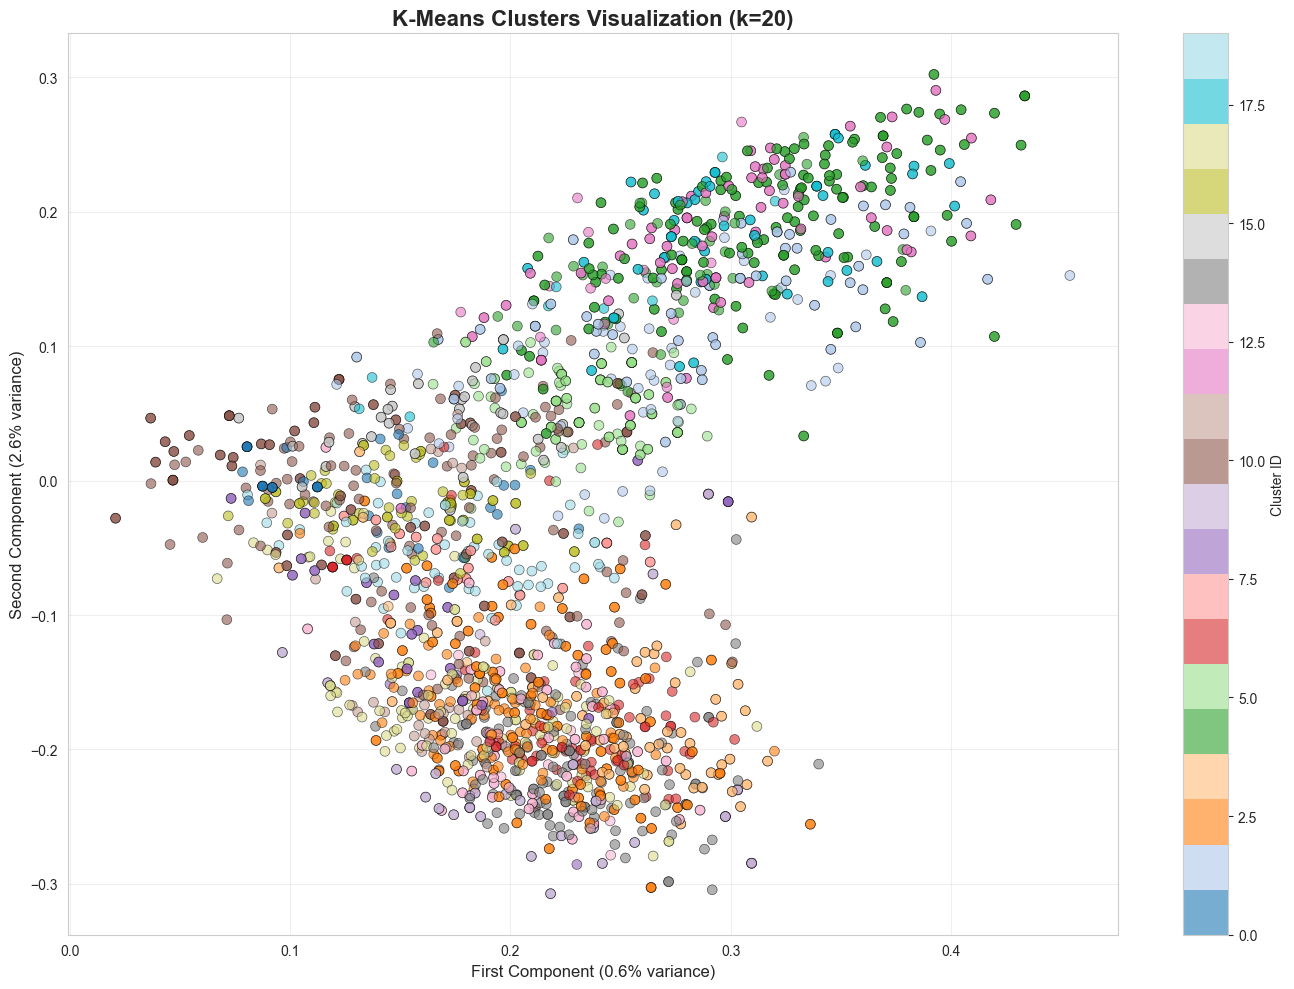

In [17]:
# ============================================================================
# STEP 8: Visualize Clusters in 2D (using PCA/t-SNE)
# ============================================================================

print("\n" + "=" * 80)
print("Visualizing Clusters in 2D Space")
print("=" * 80)

print("""
Using Truncated SVD (similar to PCA) to reduce dimensions to 2D
for visualization purposes. This shows how clusters are separated.
""")

# Use TruncatedSVD for dimensionality reduction (works with sparse matrices)
print("\nReducing dimensions to 2D...")
svd = TruncatedSVD(n_components=2, random_state=42)
X_2d = svd.fit_transform(X_all)

print(f"✓ Explained variance: {sum(svd.explained_variance_ratio_)*100:.2f}%")

# Plot clusters
plt.figure(figsize=(14, 10))
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1],
                     c=cluster_labels, cmap='tab20',
                     alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
plt.colorbar(scatter, label='Cluster ID')
plt.title(f'K-Means Clusters Visualization (k={n_clusters})',
          fontsize=16, fontweight='bold')
plt.xlabel(f'First Component ({svd.explained_variance_ratio_[0]*100:.1f}% variance)', fontsize=12)
plt.ylabel(f'Second Component ({svd.explained_variance_ratio_[1]*100:.1f}% variance)', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('cluster_visualization_2d.png', dpi=300, bbox_inches='tight')
plt.show()



Cluster Purity Analysis

Purity measures how homogeneous each cluster is with respect to
the actual medical specialties. Higher purity means the cluster
contains mostly documents from a single specialty.


Cluster Purity Rankings:
 Cluster |   Purity |   Size | Dominant Specialty
----------------------------------------------------------------------
      11 |  100.00% |     43 | Ophthalmology
      19 |  100.00% |     63 | Gastroenterology
      15 |   97.06% |     68 | Cardiovascular / Pulmonary
       7 |   95.00% |     40 | Cardiovascular / Pulmonary
       3 |   93.43% |    137 | Cardiovascular / Pulmonary
       6 |   92.94% |     85 | Orthopedic
      17 |   92.62% |    122 | Orthopedic
      13 |   89.47% |    114 | Cardiovascular / Pulmonary
       0 |   79.49% |     39 | Obstetrics / Gynecology
       5 |   64.12% |    131 | Neurology
      14 |   59.57% |    141 | Obstetrics / Gynecology
       8 |   52.63% |     57 | Orthopedic
      18 |   52.63% |    114 | Pediatrics - N

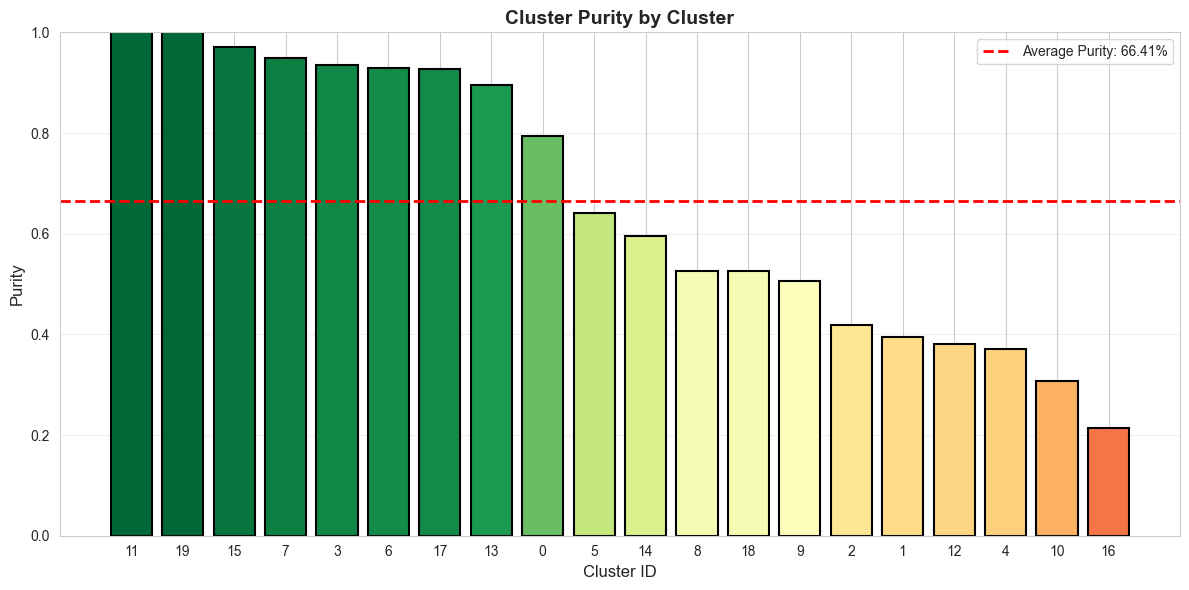

In [18]:
# ============================================================================
# STEP 9: Cluster Purity Analysis
# ============================================================================

print("\n" + "=" * 80)
print("Cluster Purity Analysis")
print("=" * 80)

print("""
Purity measures how homogeneous each cluster is with respect to
the actual medical specialties. Higher purity means the cluster
contains mostly documents from a single specialty.
""")

# Calculate purity for each cluster
cluster_purities = []

for cluster_id in range(n_clusters):
    cluster_mask = cluster_labels == cluster_id
    cluster_specialties = y_all[cluster_mask]

    if len(cluster_specialties) > 0:
        most_common_specialty = Counter(cluster_specialties).most_common(1)[0]
        purity = most_common_specialty[1] / len(cluster_specialties)
        cluster_purities.append((cluster_id, purity, most_common_specialty[0], len(cluster_specialties)))

# Sort by purity
cluster_purities.sort(key=lambda x: x[1], reverse=True)

print("\nCluster Purity Rankings:")
print(f"{'Cluster':>8} | {'Purity':>8} | {'Size':>6} | Dominant Specialty")
print("-" * 70)
for cluster_id, purity, dominant_specialty, size in cluster_purities:
    print(f"{cluster_id:8d} | {purity:8.2%} | {size:6d} | {dominant_specialty}")

average_purity = np.mean([p[1] for p in cluster_purities])
print(f"\n✓ Average Cluster Purity: {average_purity:.2%}")

# Visualize cluster purity
plt.figure(figsize=(12, 6))
cluster_ids = [p[0] for p in cluster_purities]
purities = [p[1] for p in cluster_purities]
colors = plt.cm.RdYlGn([p for p in purities])

bars = plt.bar(range(len(cluster_ids)), purities, color=colors, edgecolor='black', linewidth=1.5)
plt.axhline(y=average_purity, color='red', linestyle='--', linewidth=2,
            label=f'Average Purity: {average_purity:.2%}')
plt.xlabel('Cluster ID', fontsize=12)
plt.ylabel('Purity', fontsize=12)
plt.title('Cluster Purity by Cluster', fontsize=14, fontweight='bold')
plt.xticks(range(len(cluster_ids)), cluster_ids)
plt.ylim([0, 1])
plt.legend()
plt.grid(alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('cluster_purity.png', dpi=300, bbox_inches='tight')
plt.show()


In [19]:
# ============================================================================
# STEP 10: Business Insights and Recommendations
# ============================================================================

print("\n" + "=" * 80)
print("Business Insights for MedArchive Solutions")
print("=" * 80)

print(f"""
CLUSTERING ANALYSIS SUMMARY
===========================

Model Configuration:
-------------------
• Algorithm: K-Means Clustering
• Number of Clusters: {n_clusters}
• Total Documents Analyzed: {len(X_all)}
• Feature Dimensions: {X_all.shape[1]}

Clustering Quality:
------------------
• Silhouette Score: {silhouette_score(X_all, cluster_labels, sample_size=1000):.4f}
  (Range: -1 to 1, higher is better)
• Davies-Bouldin Index: {davies_bouldin_score(X_all, cluster_labels):.4f}
  (Lower is better, indicates good separation)
• Average Cluster Purity: {average_purity:.2%}

Discovered Topics:
-----------------""")

for cluster_id in range(min(5, n_clusters)):
    top_specialty = cluster_specialty_map[cluster_id].most_common(1)[0]
    print(f"\nCluster {cluster_id}: {top_specialty[0]}-focused documents")
    print(f"  • Keywords: {', '.join(cluster_topics[cluster_id][:8])}")
    print(f"  • Cluster Size: {Counter(cluster_labels)[cluster_id]} documents")
    print(f"  • Dominant Specialty: {top_specialty[0]} ({top_specialty[1]} docs)")

print(f"""

BUSINESS VALUE FOR MEDARCHIVE SOLUTIONS
========================================

1. DOCUMENT ORGANIZATION & DISCOVERY
   ✓ Automatically identify {n_clusters} distinct clinical topics
   ✓ Enable topic-based document search and retrieval
   ✓ Discover sub-specialties within broader categories

2. QUALITY ASSURANCE
   ✓ Clusters with low purity may indicate documents that are:
     • Difficult to classify
     • Potentially mislabeled
     • Require manual review
   ✓ Clusters with high purity validate classification quality

3. WORKFLOW OPTIMIZATION
   ✓ Identify common procedure types across specialties
   ✓ Batch-process similar documents together
   ✓ Optimize routing rules based on discovered patterns

4. TRAINING DATA ENHANCEMENT
   ✓ Use cluster membership to identify:
     • Under-represented document types
     • Areas needing more training examples
     • Potential new specialty categories

5. BUSINESS INTELLIGENCE
   ✓ Understand distribution of case types
   ✓ Identify trending medical procedures
   ✓ Support resource allocation decisions

RECOMMENDATIONS
===============

1. HIGH-PURITY CLUSTERS (>{(average_purity+0.1):.0%} purity):
   → Use as gold-standard training examples
   → Validate classification model performance
   → Create specialized sub-category routing

2. LOW-PURITY CLUSTERS (<{(average_purity-0.1):.0%} purity):
   → Flag for manual review
   → Consider as multi-specialty cases
   → Potential candidates for new specialty categories

3. PRODUCTION INTEGRATION:
   → Add cluster labels as additional metadata
   → Use for document similarity search
   → Enable "find similar cases" feature

4. FUTURE WORK:
   → Test hierarchical clustering for sub-specialties
   → Combine with classification model for hybrid routing
   → Monitor cluster drift over time as new cases arrive
""")



Business Insights for MedArchive Solutions

CLUSTERING ANALYSIS SUMMARY

Model Configuration:
-------------------
• Algorithm: K-Means Clustering
• Number of Clusters: 20
• Total Documents Analyzed: 2464
• Feature Dimensions: 5000

Clustering Quality:
------------------
• Silhouette Score: 0.0461
  (Range: -1 to 1, higher is better)
• Davies-Bouldin Index: 4.7670
  (Lower is better, indicates good separation)
• Average Cluster Purity: 66.41%

Discovered Topics:
-----------------

Cluster 0: Obstetrics / Gynecology-focused documents
  • Keywords: fetal, weeks days, placenta, delivery, weeks, gestation, consistent, days
  • Cluster Size: 39 documents
  • Dominant Specialty: Obstetrics / Gynecology (31 docs)

Cluster 1: Neurology-focused documents
  • Keywords: pain, patient, history, right, states, does, symptoms, left
  • Cluster Size: 170 documents
  • Dominant Specialty: Neurology (67 docs)

Cluster 2: Cardiovascular / Pulmonary-focused documents
  • Keywords: procedure, patient, lob

In [20]:
# ============================================================================
# STEP 11: Save Clustering Results
# ============================================================================

print("\n" + "=" * 80)
print("Saving Clustering Results")
print("=" * 80)

# Save the clustering model
clustering_path = 'artifacts/kmeans_model.joblib'
joblib.dump(kmeans_final, clustering_path)
print(f"✓ Saved: {clustering_path}")

# Save cluster labels
np.save('artifacts/cluster_labels.npy', cluster_labels)
print(f"✓ Saved: artifacts/cluster_labels.npy")

# Save cluster analysis results
cluster_analysis = {
    'n_clusters': int(n_clusters),
    'silhouette_score': float(silhouette_score(X_all, cluster_labels, sample_size=1000)),
    'davies_bouldin_score': float(davies_bouldin_score(X_all, cluster_labels)),
    'average_purity': float(average_purity),
    'cluster_sizes': {int(k): int(v) for k, v in Counter(cluster_labels).items()},
    'cluster_topics': {int(k): v[:10] for k, v in cluster_topics.items()}
}

import json
with open('artifacts/cluster_analysis.json', 'w') as f:
    json.dump(cluster_analysis, f, indent=2)
print(f"✓ Saved: artifacts/cluster_analysis.json")

# Create a summary DataFrame
results_df = pd.DataFrame({
    'cluster_id': cluster_labels,
    'specialty': y_all
})
results_df.to_csv('artifacts/clustering_results.csv', index=False)
print(f"✓ Saved: artifacts/clustering_results.csv")

print("\n" + "=" * 80)
print("NOTEBOOK 3 COMPLETE")
print("=" * 80)
print("\nAll clustering analysis artifacts saved in /artifacts directory")
print("Ready for deployment and integration with classification system!")


Saving Clustering Results
✓ Saved: artifacts/kmeans_model.joblib
✓ Saved: artifacts/cluster_labels.npy
✓ Saved: artifacts/cluster_analysis.json
✓ Saved: artifacts/clustering_results.csv

NOTEBOOK 3 COMPLETE

All clustering analysis artifacts saved in /artifacts directory
Ready for deployment and integration with classification system!
